In [ ]:
import time
import math
import numpy as np
from problems import sixth_order
from pinn import PINN, make_points
from plots_and_stats import plot_errors, plot_comparison
np.random.seed(1234)

a1 = 1.000, a2 = -1.000, a3 = -2.800, a4 = -0.300, a5 = -0.600, a6 = 0.100,
 b1 = 6.000, b2 = -1.525, b3 = 0.113


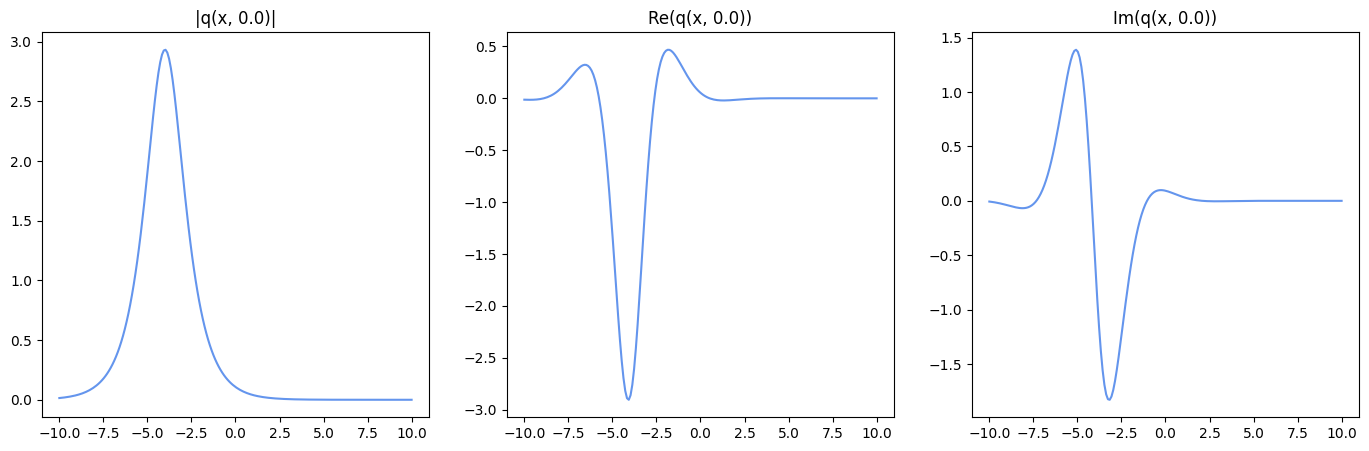

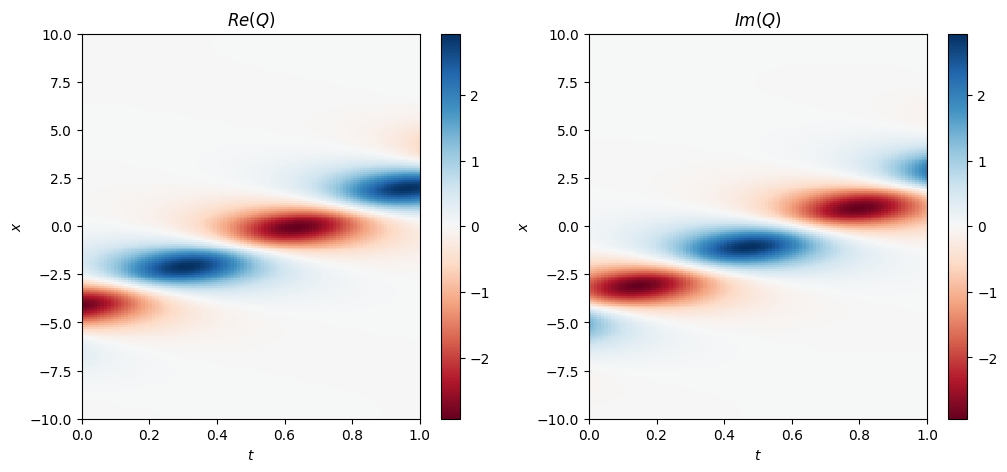

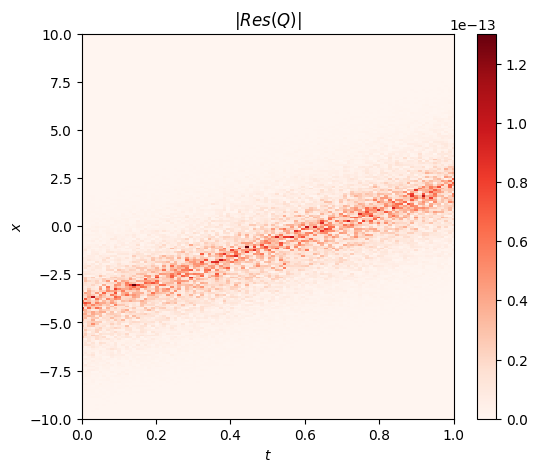

In [ ]:
#domain setting
x_0=-10.
x_1=10.
t_0=0.
t_1=1.
#problem setting
a1 = 1
a2 = -1
a4 = -0.3
a6 = 0.1
b1 = 6
khi = 1
a_param = 0.5
x0_param = 4
theta0 = math.pi/3
problem = sixth_order(x_0, x_1, t_0, t_1, a1, a2, a4, a6, b1, khi, a_param, x0_param, theta0)
#info about the problem
problem.show_params()
problem.show_ic(x_resolution=200)
problem.show_solution(x_resolution=200, t_resolution=100, show_residual=True)

In [ ]:
#data for training
X_i_train, U_i_train, V_i_train, X_b_train, X_grid = make_points(problem, init_points_amt=400, bound_points_amt=100, grid_resolution_x=200, grid_resolution_t=100)
#data for metrics evaluation
x_parts=200
t_parts=100
x=np.linspace(x_0,x_1,x_parts)
t=np.linspace(t_0,t_1,t_parts)
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None])) #test input for PINN
Q_truth=problem.q(X,T) #ground truth
layers = [2, 100, 100, 100, 2] #network topology

In [ ]:
%%time
model = PINN(problem, layers, X_i_train, U_i_train, V_i_train, X_b_train, X_grid)
##Setting hyperparameters
#verbosity
model.verbosity = 10000 #loss output frequency
model.make_res_gif = False #makes gif with residual history
#points generation options
model.points_gen_method = "second" #"random"/first"/"second"/"third"
model.points_gen_freq = 10 #points generation frequency
model.points_am = 5000 #amount of collocation points
#optimization options
model.adam_steps = 200000
model.lbfgs_steps = 0
model.nncg_steps = 0
model.adam_step_decay = 0.998
model.lbfgs_step_decay = 0.990
model.nncg_step_decay = 0.990
model.decay_freq = 100
#loss balancing options
model.loss_bal_method = "none" #"none"/"relobralo"
model.bal_freq = 1000 #loss rebalancing frequency
model.lambda_i = 950/1000
model.lambda_b = 49/1000
model.lambda_f = 1/1000
model.extinction = 0.37 #extinction coefficient for ReLoBRaLo
#causal training
model.causal_loss = True
model.epsilon = 0.79
model.t_partition = 50 #number of parts in the [t_0, t_1] division

model.train()

Training started with second points generation method, none loss balancing and causal loss
200000 steps of ADAM:
Iter 10000, Loss: 1.099e-03, Loss_i: 4.61e-04, Loss_b: 5.32e-04, Loss_f: 6.34e-01
Iter 20000, Loss: 4.224e-04, Loss_i: 6.58e-05, Loss_b: 1.95e-04, Loss_f: 3.50e-01
Iter 30000, Loss: 5.500e-04, Loss_i: 1.48e-04, Loss_b: 2.14e-04, Loss_f: 3.99e-01
Iter 40000, Loss: 1.535e-03, Loss_i: 9.62e-04, Loss_b: 1.20e-03, Loss_f: 5.62e-01
Iter 50000, Loss: 3.411e-04, Loss_i: 6.72e-05, Loss_b: 1.39e-04, Loss_f: 2.70e-01
Iter 60000, Loss: 9.562e-05, Loss_i: 1.04e-05, Loss_b: 6.31e-05, Loss_f: 8.26e-02
Iter 70000, Loss: 6.651e-05, Loss_i: 1.37e-06, Loss_b: 5.04e-05, Loss_f: 6.28e-02
Iter 80000, Loss: 7.716e-05, Loss_i: 2.65e-05, Loss_b: 3.87e-05, Loss_f: 5.01e-02
Iter 90000, Loss: 1.532e-05, Loss_i: 1.86e-06, Loss_b: 8.98e-06, Loss_f: 1.31e-02
Iter 100000, Loss: 2.761e-05, Loss_i: 9.28e-06, Loss_b: 6.84e-06, Loss_f: 1.85e-02
Iter 110000, Loss: 8.735e-06, Loss_i: 2.47e-06, Loss_b: 5.98e-06, 

In [ ]:
import torch
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
torch.save(model, f'model(6th_order).pth')
#model = torch.load(f'model(6th_order).pth', map_location=device)

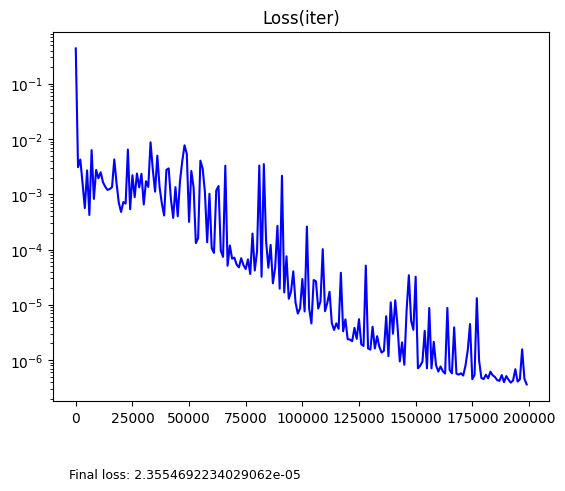

In [ ]:
model.train_hist(logscale=True, step=1000)

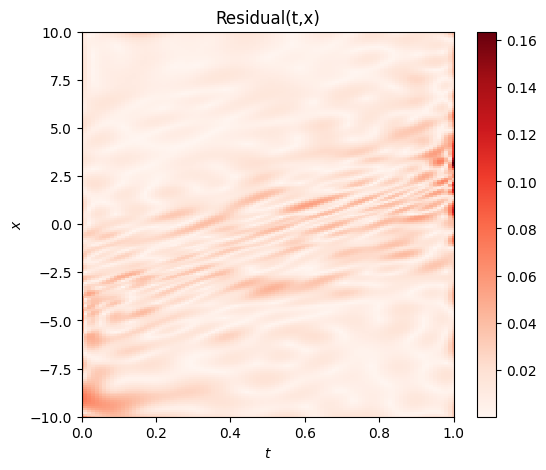

In [ ]:
model.plot_residual(X, T)

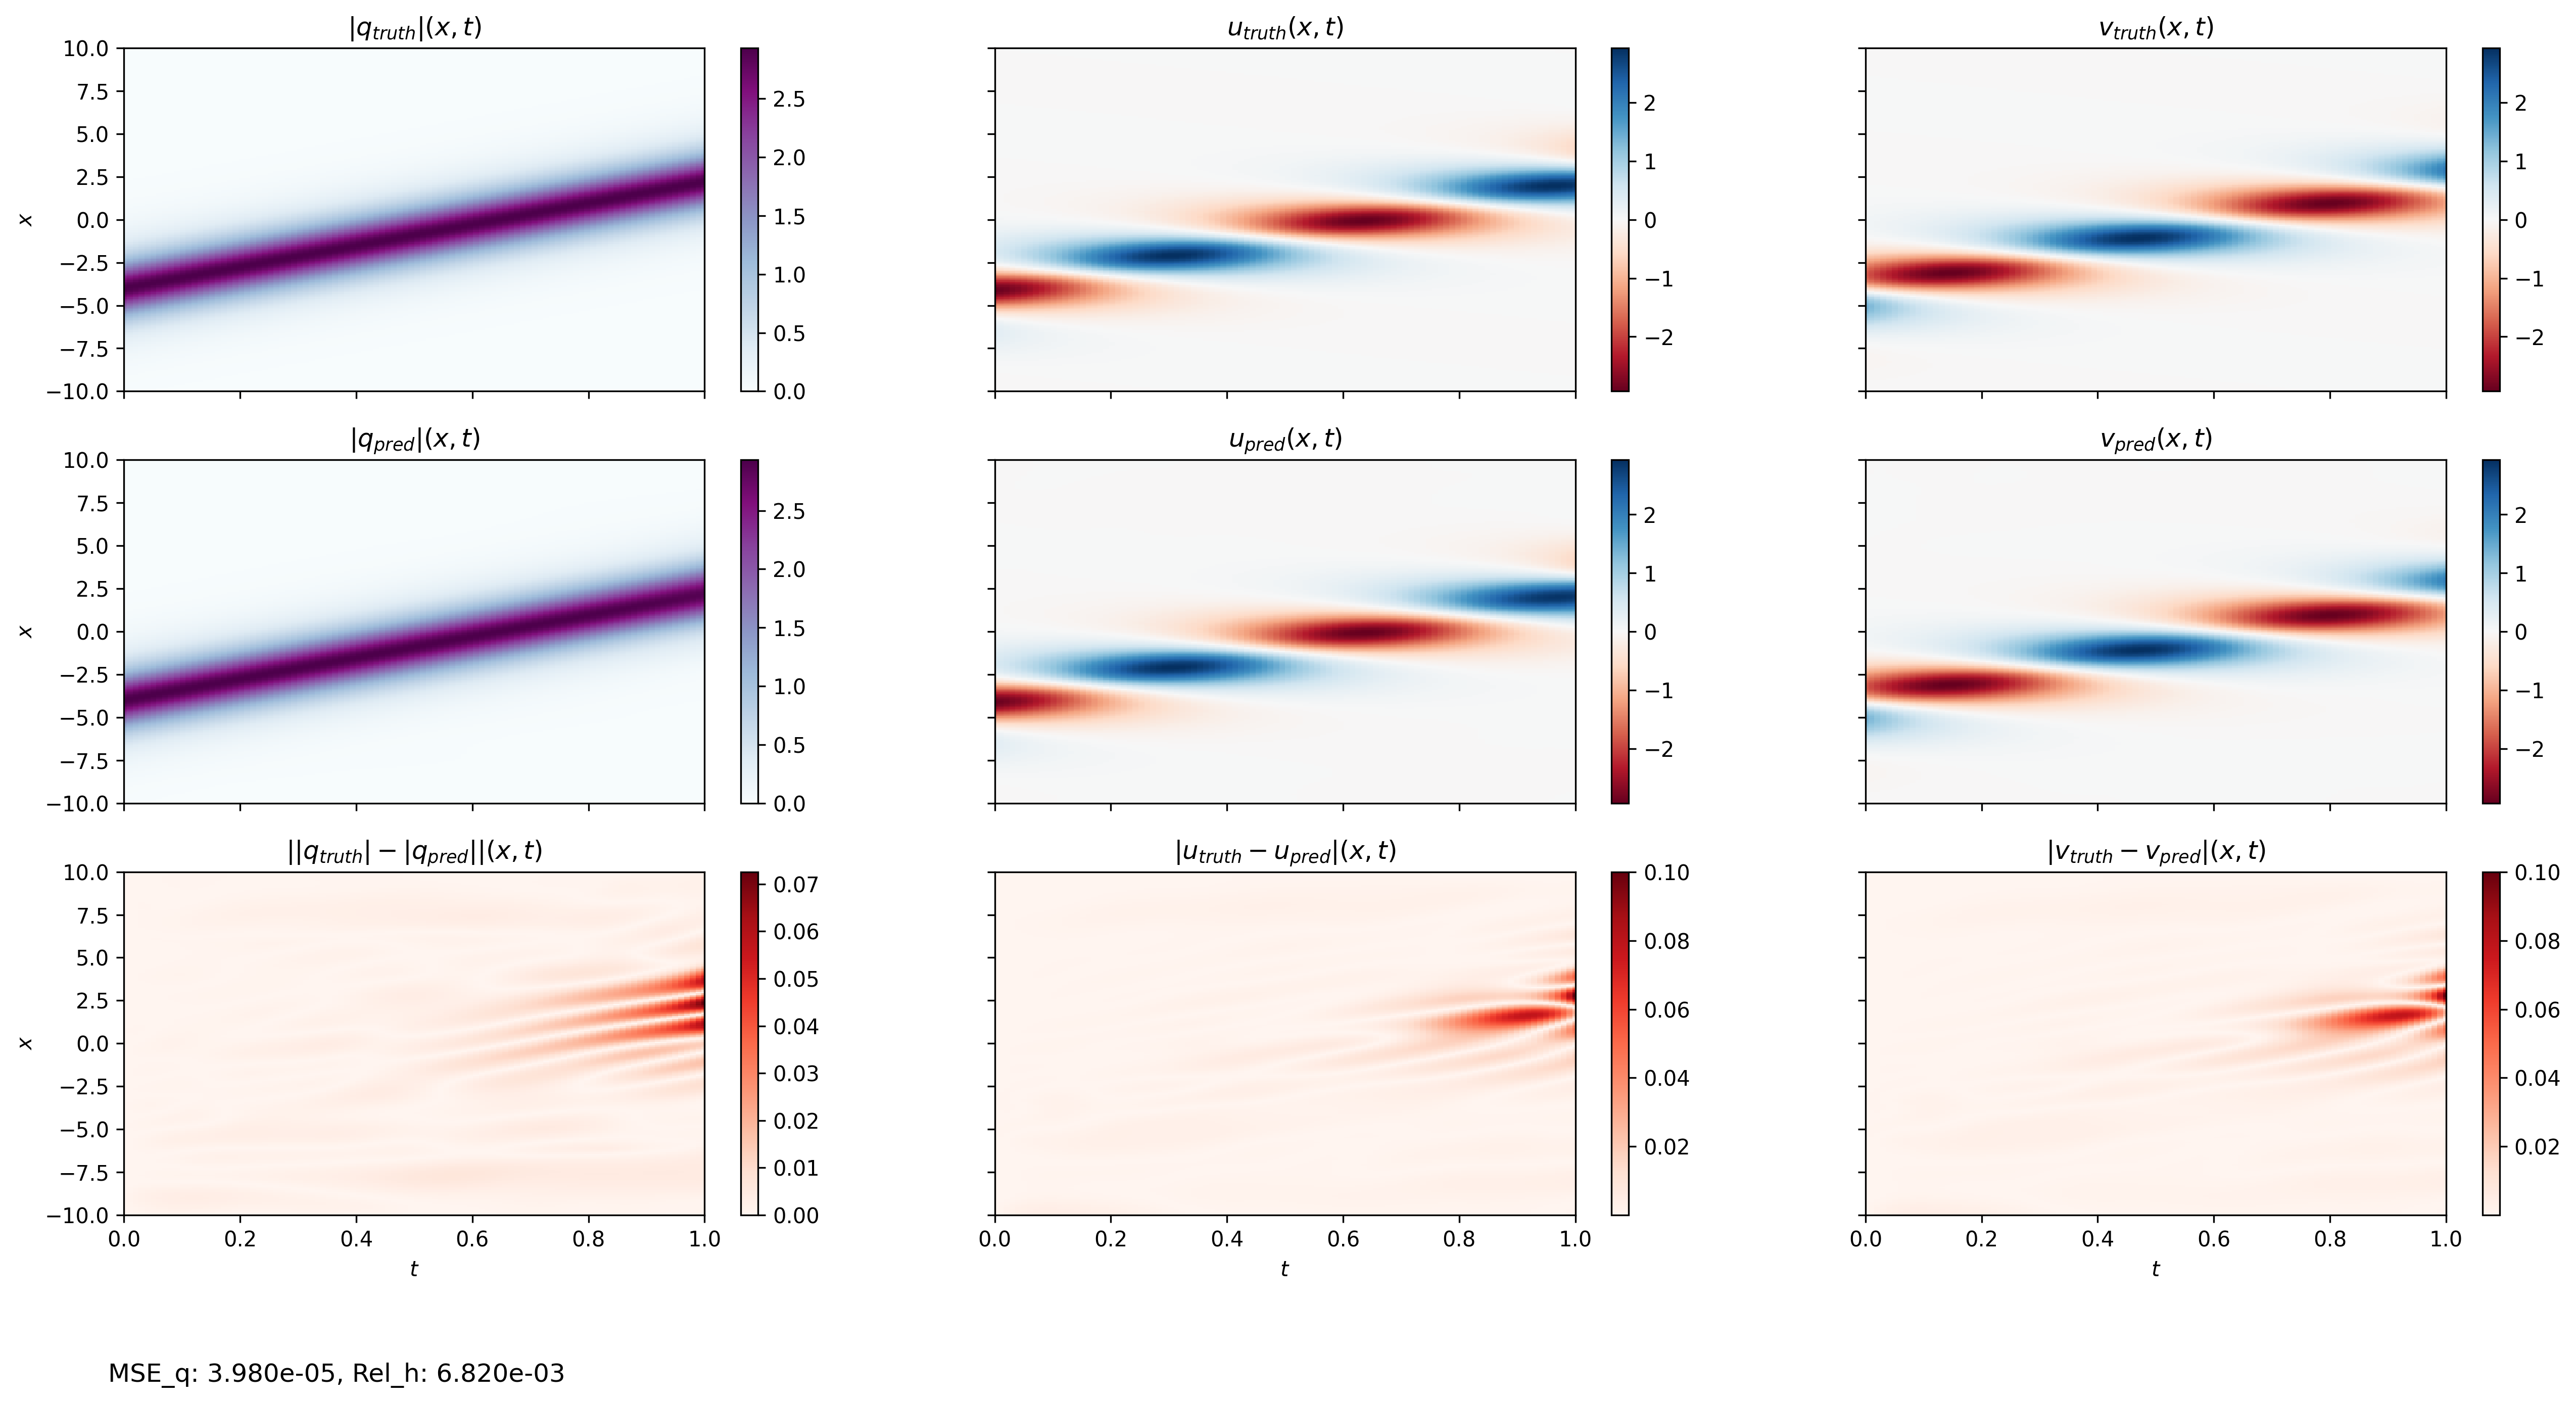

{'MSE_q': 3.980364400542595e-05, 'Rel_h': 0.006820257248278939}

In [ ]:
u_pred, v_pred, f_u_pred, f_v_pred = model.predict(X_star)
Q_pred=u_pred.reshape((t_parts, x_parts)) + 1j*v_pred.reshape((t_parts, x_parts))
plot_comparison(X, T, Q_pred, Q_truth, savefig=True, namefig="test_comparison(6th_order).png")

Dimensionality by x: 200, by t: 100


{'Lw1_per_max': 0.09950036781357172,
 'Lw1_per_mean': 0.04940222916520285,
 'Lw2_per_max': 0.08014997745092262,
 'Lw2_per_mean': 0.03828451649012033,
 'Rel_h': 0.006820257248278939}

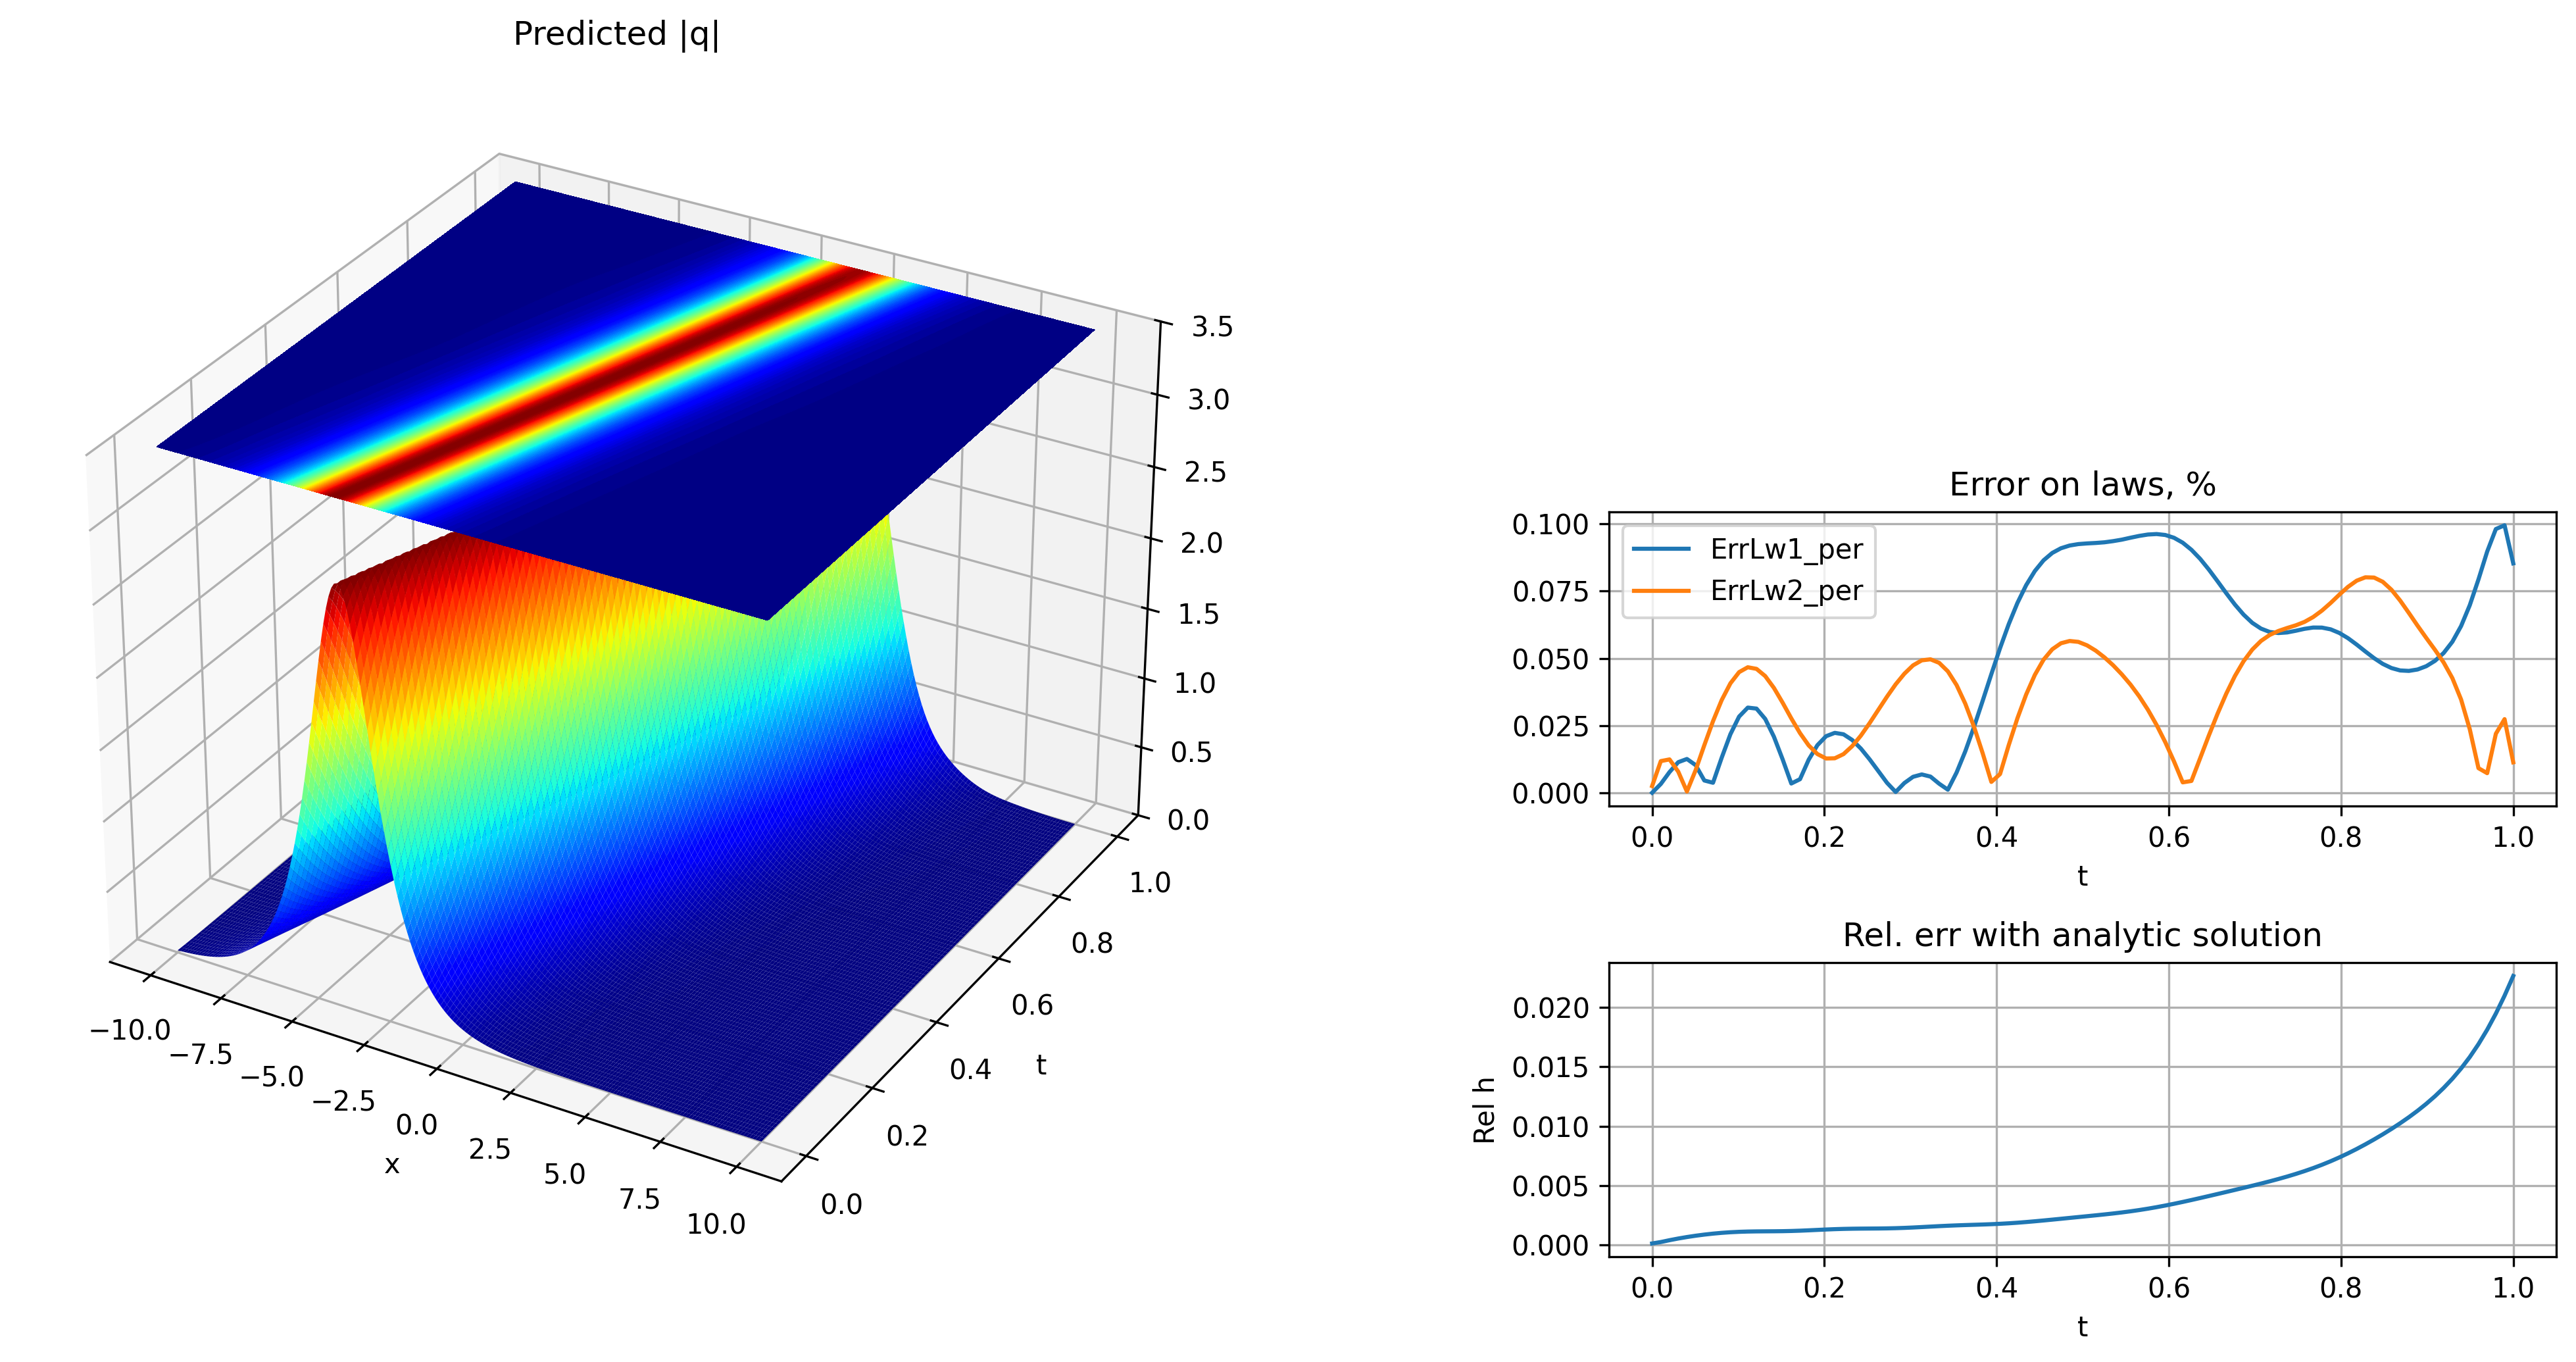

In [ ]:
plot_errors(X, T, Q_pred, Q_truth, savefig=True, namefig="test_errors(6th_order).png", savetable=False, nametable="data(6th_order).csv")